# Лабораторная работа №1
#### Постановка задачи:
##### Цель и задачи работы:
1. Познакомиться с понятием «большие данные» и способами их обработки;
2. Познакомиться с инструментом Apache Spark и возможностями, которые он предоставляет для обработки больших данных.
3. Получить навыки выполнения разведочного анализа данных использованием pyspark.

#### Необходимо провести разведочный анализ датасета с определением:
+ типов признаков в датасете;
+ пропущенных значений и их устранением;
+ выбросов и их устранением;
+ расчетом статистических показателей признаков (средних, квартилей и т.д.);
+ визуализацией распределения наиболее важных признаков;
+ корреляций между признаками.

In [1]:
# Import other modules not related to PySpark
import os
import sys
import pandas as pd
from pandas import DataFrame
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib
import math
from IPython.core.interactiveshell import InteractiveShell
from datetime import *
import statistics as stats
from pyspark.sql.functions import percentile_approx, mean, avg, stddev, min, max, when, col, count, length, lag, expr, percent_rank
from pyspark.sql.window import Window
import pyspark.sql.functions as F
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
from pyspark.sql.functions import round
InteractiveShell.ast_node_interactivity = "all" 
%matplotlib inline

In [2]:
#Import PySpark related modules
import pyspark
from pyspark.rdd import RDD
from pyspark.sql import Row
from pyspark.sql import DataFrame
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql import functions
from pyspark.sql.functions import lit, desc, col, size, array_contains\
, isnan, udf, hour, array_min, array_max, countDistinct
from pyspark.sql.types import *

MAX_MEMORY = '8G'
# Initialize a spark session.
conf = pyspark.SparkConf().setMaster("local[*]") \
        .set('spark.executor.heartbeatInterval', 10000) \
        .set('spark.network.timeout', 10000) \
        .set("spark.core.connection.ack.wait.timeout", "3600") \
        .set("spark.executor.memory", MAX_MEMORY) \
        .set("spark.driver.memory", MAX_MEMORY)
def init_spark():
    spark = SparkSession \
        .builder \
        .appName("Pyspark guide") \
        .config(conf=conf) \
        .getOrCreate()
    return spark

spark = init_spark()
filename_data = 'work/data/sampled.csv'
# Load the main data set into pyspark data frame 
df = spark.read.csv(filename_data,header=True, mode="DROPMALFORMED", inferSchema=True)
from pyspark.sql.functions import col, array
from pyspark.ml.feature import Bucketizer
from IPython.display import display, clear_output
from IPython.display import display

In [3]:
print(df.count())

822528


### Выполняем разведочный анализ датасета с определением:
#### 1. Типы признаков в датасете:

In [4]:
df = df.drop("legId", "searchDate", "fareBasisCode", "segmentsArrivalTimeEpochSeconds", "segmentsArrivalTimeRaw", "segmentsEquipmentDescription",
             "segmentsArrivalAirportCode", "segmentsDepartureAirportCode", "segmentsAirlineCode", "segmentsCabinCode", "segmentsAirlineName",
            "segmentsDepartureTimeRaw", "segmentsDepartureTimeEpochSeconds", "segmentsDistance", "travelDuration", "isRefundable", "flightDate")

In [5]:
print('Обзор данных')
df.printSchema()

Обзор данных
root
 |-- startingAirport: string (nullable = true)
 |-- destinationAirport: string (nullable = true)
 |-- elapsedDays: integer (nullable = true)
 |-- isBasicEconomy: boolean (nullable = true)
 |-- isNonStop: boolean (nullable = true)
 |-- baseFare: double (nullable = true)
 |-- totalFare: double (nullable = true)
 |-- seatsRemaining: integer (nullable = true)
 |-- totalTravelDistance: integer (nullable = true)
 |-- segmentsDurationInSeconds: string (nullable = true)



In [6]:
print('Обзор колонок')
pd.DataFrame(df.dtypes, columns = ['Имя колонки','Тип данных'])
df.limit(10).toPandas()

Обзор колонок


,Имя колонки,Тип данных
0,startingAirport,string
1,destinationAirport,string
2,elapsedDays,int
3,isBasicEconomy,boolean
4,isNonStop,boolean
5,baseFare,double
6,totalFare,double
7,seatsRemaining,int
8,totalTravelDistance,int
9,segmentsDurationInSeconds,string


,startingAirport,destinationAirport,elapsedDays,isBasicEconomy,isNonStop,baseFare,totalFare,seatsRemaining,totalTravelDistance,segmentsDurationInSeconds
0,ATL,BOS,0,False,True,367.98,410.18,1,947,9840
1,ATL,DEN,0,False,False,262.33,305.61,7,1375,9300||7500
2,ATL,DFW,0,False,False,174.88,211.60,2,1399,8100||9060
3,ATL,MIA,0,False,False,503.51,564.87,5,1866,8100||11940
4,ATL,OAK,0,False,False,528.37,596.10,2,2393,12060||8880||4740
5,ATL,PHL,0,False,True,636.28,698.60,3,667,7320
6,ATL,SFO,0,False,False,496.74,557.60,2,2161,11820||10080
7,BOS,CLT,0,False,True,734.88,804.60,1,728,8940
8,BOS,MIA,1,False,False,301.40,347.61,1,2054,10800||11400
9,BOS,ORD,0,False,True,185.58,214.10,1,862,10620


### Обозначим типы признаков:
1. startingAirport: Трехсимвольный код аэропорта для начального местоположения.
2. destinationAirport (аэропорт назначения): Трехсимвольный код аэропорта для места прибытия.
3. elapsedDays (истекшие дни): Количество истекших дней (обычно 0).
4. isBasicEconomy: Булево значение, указывающее, является ли билет базовым экономичным.
5. isRefundable: Булево значение, указывающее, можно ли вернуть деньги за билет.
6. isNonStop: Булево значение, указывающее, является ли рейс беспосадочным.
7. baseFare (базовый тариф): Цена билета (в USD).
8. totalFare: Цена билета (в USD), включая налоги и другие сборы.
9. seatsRemaining: Целое число для количества оставшихся мест.
10. totalTravelDistance (общее расстояние): Общее расстояние поездки в милях.
11. segmentsDurationInSeconds: Строка, содержащая продолжительность полета (в секундах) для каждого этапа путешествия. Записи для каждого этапа разделяются символом '||'.

Последняя строка датасета содержит значения в строковом формате, хотя представляют собой числа, разделенные ||.
Если представить эти значения в виде чисел и сложить, то мы получим общую продолжительность полёта, выраженную как количественный признак.

In [7]:
# Создаем UDF (User Defined Function) для вычисления общей продолжительности полета
def calculate_total_duration(segments_duration):
    total_duration = sum([int(duration) for duration in segments_duration.split("||")])
    return total_duration

# Регистрируем UDF
calculate_total_duration_udf = udf(calculate_total_duration, IntegerType())

# Добавляем новую колонку с общей продолжительностью полета
df = df.withColumn("totalFlightDurationInSeconds", calculate_total_duration_udf(col("segmentsDurationInSeconds")))

# Показываем результат
df.limit(10).toPandas()

,startingAirport,destinationAirport,elapsedDays,isBasicEconomy,isNonStop,baseFare,totalFare,seatsRemaining,totalTravelDistance,segmentsDurationInSeconds,totalFlightDurationInSeconds
0,ATL,BOS,0,False,True,367.98,410.18,1,947,9840,9840
1,ATL,DEN,0,False,False,262.33,305.61,7,1375,9300||7500,16800
2,ATL,DFW,0,False,False,174.88,211.60,2,1399,8100||9060,17160
3,ATL,MIA,0,False,False,503.51,564.87,5,1866,8100||11940,20040
4,ATL,OAK,0,False,False,528.37,596.10,2,2393,12060||8880||4740,25680
5,ATL,PHL,0,False,True,636.28,698.60,3,667,7320,7320
6,ATL,SFO,0,False,False,496.74,557.60,2,2161,11820||10080,21900
7,BOS,CLT,0,False,True,734.88,804.60,1,728,8940,8940
8,BOS,MIA,1,False,False,301.40,347.61,1,2054,10800||11400,22200
9,BOS,ORD,0,False,True,185.58,214.10,1,862,10620,10620


In [8]:
# Теперь можем удалить изначальную колонку, она нам не понадобится
df = df.drop("segmentsDurationInSeconds")

### 2. Выявление пропущенных значений и их устранение:
#### Определяем пропущенные значения:

In [9]:
string_columns = ['startingAirport', 'destinationAirport', 'isBasicEconomy', 'isNonStop', 'flightDate', 'segmentsAirlineName', 'segmentsDurationInSeconds']
numeric_columns = ['elapsedDays', 'baseFare', 'totalFare', 'seatsRemaining', "totalTravelDistance", "totalFlightDurationInSeconds"]

def view_missing_values_in_columns(string_columns, numeric_columns):
    missing_values = {}
    for index, column in enumerate(df.columns):
        if column in string_columns:
            missing_count = df.filter(col(column).eqNullSafe(None) | col(column).isNull()).count()
        else: 
            missing_count = df.where(col(column).isin([None,np.nan]) | col(column).isNull()).count()
        missing_values.update({column:missing_count})
    
    return missing_values

pd.DataFrame.from_dict([view_missing_values_in_columns(string_columns, numeric_columns)])

,startingAirport,destinationAirport,elapsedDays,isBasicEconomy,isNonStop,baseFare,totalFare,seatsRemaining,totalTravelDistance,totalFlightDurationInSeconds
0,0,0,0,0,0,0,0,0,60888,0


#### Осуществляем удаление найденных пропущенных значений:

In [10]:
df = df.dropna()
pd.DataFrame.from_dict([view_missing_values_in_columns(string_columns, numeric_columns)])

,startingAirport,destinationAirport,elapsedDays,isBasicEconomy,isNonStop,baseFare,totalFare,seatsRemaining,totalTravelDistance,totalFlightDurationInSeconds
0,0,0,0,0,0,0,0,0,0,0


### 3. Определение выбросов и их устранение:
#### После обработки пропущенных значений формируем статистических данных для числовых столбцов датафрейма, чтобы определить оставшееся количество строк в фрейме:

In [11]:
df.select(df.elapsedDays, df.baseFare, df.totalFare, df.seatsRemaining, df.totalTravelDistance, df.totalFlightDurationInSeconds).describe().toPandas()

,summary,elapsedDays,baseFare,totalFare,seatsRemaining,totalTravelDistance,totalFlightDurationInSeconds
0,count,761640,761640,761640,761640,761640,761640
1,mean,0.14591145423034504,304.28565622866535,349.3850019826068,6.3966493356441365,1609.3298723806522,16958.24870017331
2,stddev,0.3530176559001878,182.18866593988074,197.91373243197847,2.49191088222912,857.6568222107161,6968.976632825525
3,min,0,8.72,23.97,0,89,2760
4,max,1,7000.0,7548.6,10,4498,47340


#### Теперь определим выбросы и удалим выбросы методом межквартильного интервала (Нахождение 25% и 75% квартилей, межквартильного диапазона).

In [12]:
outlier_columns = ['baseFare', 'totalFare', 'seatsRemaining', 'totalTravelDistance', 'totalFlightDurationInSeconds']

for column in outlier_columns:
    Q1 = df.approxQuantile(column, [0.25], relativeError=0)[0]
    Q3 = df.approxQuantile(column, [0.75], relativeError=0)[0]
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    bucketizer = Bucketizer(splits=[-float('Inf'), lower_bound, upper_bound, float('Inf')],
                        inputCol=column,
                        outputCol='bins')
    df_bins = bucketizer.setHandleInvalid('keep').transform(df.select(column))
    print("Таблица с выбросами для", column)
    df_bins.groupBy('bins').count().toPandas()
    
for column in outlier_columns:
    Q1 = df.approxQuantile(column, [0.25], relativeError=0)[0]
    Q3 = df.approxQuantile(column, [0.75], relativeError=0)[0]
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df = df.filter(col(column).between(lower_bound, upper_bound))
    
df.select(df.elapsedDays, df.baseFare, df.totalFare, df.seatsRemaining, df.totalTravelDistance, df.totalFlightDurationInSeconds).describe().toPandas()

Таблица с выбросами для baseFare


,bins,count
0,1.0,750794
1,2.0,10846


Таблица с выбросами для totalFare


,bins,count
0,1.0,751074
1,2.0,10566


Таблица с выбросами для seatsRemaining


,bins,count
0,1.0,761640


Таблица с выбросами для totalTravelDistance


,bins,count
0,1.0,761640


Таблица с выбросами для totalFlightDurationInSeconds


,bins,count
0,1.0,760768
1,2.0,872


,summary,elapsedDays,baseFare,totalFare,seatsRemaining,totalTravelDistance,totalFlightDurationInSeconds
0,count,749465,749465,749465,749465,749465,749465
1,mean,0.14385861914832582,292.8894589073537,337.0688856984663,6.40350116416377,1592.302805334472,16810.915786594436
2,stddev,0.3509465503182265,152.83356203628946,166.537984341252,2.490831905878276,847.4745822946386,6864.532467883248
3,min,0,8.72,23.97,0,89,2760
4,max,1,761.86,838.71,10,4234,37740


### 4. Расчет статистических показателей признаков (средних, квартилей и т.д.)
#### Выведем типы признаков:

In [13]:
pd.DataFrame(df.dtypes, columns = ['Название колонки','Тип данных'])

,Название колонки,Тип данных
0,startingAirport,string
1,destinationAirport,string
2,elapsedDays,int
3,isBasicEconomy,boolean
4,isNonStop,boolean
5,baseFare,double
6,totalFare,double
7,seatsRemaining,int
8,totalTravelDistance,int
9,totalFlightDurationInSeconds,int


#### Статистические показатели для количественных признаков:

**Среднее (Mean):** Обычно является первым показателем, который рассчитывается для числовых данных. Среднее значение предоставляет информацию о центре распределения данных.

**Медиана (Median):** Это значение, которое делит ваш набор данных на две равные части. Она устойчива к выбросам в данных и используется для оценки "среднего" значения, если данные имеют асимметричное распределение.

**Квартили (Quartiles):** Квартили представляют собой три точки данных, которые делят упорядоченный набор данных на четыре равные части. 25-й квартиль - это значение, которое меньше или равно 25% данных, а 75-й квартиль - это значение, которое меньше или равно 75% данных.

**Мода (Mode):** Значение, которое встречается наиболее часто в вашем наборе данных. Мода полезна для определения наиболее распространенных значений в категориальных данных.

**Стандартное отклонение (Standard Deviation):** Это мера разброса данных относительно их среднего значения. Она предоставляет информацию о том, насколько разнообразны значения в вашем наборе данных.

**Минимум (Min):** Минимальный показатель колонки.

**Максимум (Max):** Максимальный показатель колонки.

**Диапазон значений (Range):** Простое измерение, которое показывает разницу между самым большим и самым маленьким значениями в наборе данных.

**Квантили (Quantiles):** Квантили обобщают понятие квартиля. В то время как квартили делят данные на четыре равные части, квантили позволяют делить данные на более произвольное количество частей.

In [14]:
def calculate_statistics(df, columns):
    statistics = {'Statistic': ['Mean', 'Median', 'Mode', 'Standard Deviation', 'Min', 'Max', 'Range', '25th Quantile', '75th Quantile', '95th Quartiles']}

    for column in columns:
        mode_column = df.groupBy(column).count().sort(F.col("count").desc()).select(column).limit(1).collect()[0][0]

        column_values = [
            df.agg({column: "avg"}).collect()[0][0],  # среднее значение
            df.approxQuantile(column, [0.5], 0.001)[0],  # медиана
            mode_column,  # мода
            df.agg({column: "stddev"}).collect()[0][0],  # стандартное отклонение
            df.agg({column: 'min'}).collect()[0][0], # минимум
            df.agg({column: 'max'}).collect()[0][0], # максимум
            df.agg({column: 'max'}).collect()[0][0] - df.agg({column: 'min'}).collect()[0][0],  # диапазон
            df.approxQuantile(column, [0.25], 0.001)[0],  # 25-й квантиль
            df.approxQuantile(column, [0.75], 0.001)[0],  # 50-й квантиль
            df.approxQuantile(column, [0.95], 0.001)[0]   # 75-й квантиль
        ]
        
        statistics[f'{column}'] = column_values

    # Создаем DataFrame из словаря
    statistics_df = pd.DataFrame(statistics)

    return statistics_df

# Список столбцов для подсчета статистики
columns = ['elapsedDays', 'baseFare', 'totalFare', 'seatsRemaining', 'totalTravelDistance', 'totalFlightDurationInSeconds']

# Получаем DataFrame со статистикой
result_df = calculate_statistics(df, columns)
display(result_df)

,Statistic,elapsedDays,baseFare,totalFare,seatsRemaining,totalTravelDistance,totalFlightDurationInSeconds
0,Mean,0.143859,292.889459,337.068886,6.403501,1592.302805,16810.915787
1,Median,0.000000,268.840000,308.600000,7.000000,1433.000000,16200.000000
2,Mode,0.000000,208.370000,148.600000,7.000000,185.000000,12600.000000
3,Standard Deviation,0.350947,152.833562,166.537984,2.490832,847.474582,6864.532468
4,Min,0.000000,8.720000,23.970000,0.000000,89.000000,2760.000000
5,Max,1.000000,761.860000,838.710000,10.000000,4234.000000,37740.000000
6,Range,1.000000,753.140000,814.740000,10.000000,4145.000000,34980.000000
7,25th Quantile,0.000000,169.300000,201.600000,5.000000,872.000000,11520.000000
8,75th Quantile,0.000000,399.070000,454.600000,9.000000,2388.000000,21960.000000
9,95th Quartiles,1.000000,570.230000,638.200000,9.000000,2978.000000,28560.000000


In [18]:
print(df.select('startingAirport').distinct().count())

16


In [19]:
print(df.select('destinationAirport').distinct().count())

16


#### Статистические показатели для количественных признаков с использованием категориальных:
**Количество (count)** - Указывает какое количество значений имеется в колонке.

**Процентиль (percentile)** - Процентиль это числовое значение, которое делит упорядоченный набор данных на 100 равных частей. Каждый процентиль представляет собой точку данных, ниже которой падает определенная процентная доля значений в наборе данных (в нашем случае: 25%, 50%, 75% и 95%).

**Минимум (min)** - Минимальный количественный показатель категориального признака.

**Максимум (max)** - Максимальный количественный показатель категориального признака.

**Среднее (Mean)** - Среднее значение количественных показателей категориального признака.

**Стандартное отклонение (stddev)** - Мера разброса данных относительно среднего значения количественных показателей категориального признака.

В нашем датасете присутствует 2 категориальных признака. Поэтому составим таблицу по каждому из показателей.

#### Статистические показатели для признака totalFare, сгруппированного по startingAirport

In [15]:
all_startingAirport = df.groupBy("startingAirport").count().collect()

startingAirport_statistic_df = []

for row in all_startingAirport:
    startingAirport = row["startingAirport"]
    count = row["count"]
    stat_dict = {'startingAirport': startingAirport, 'count': count}

    startingAirport_df = df.select(df.totalFare).filter(df.startingAirport == startingAirport)
    stats = startingAirport_df.select(
        F.percentile_approx(df.totalFare, [0.25, 0.5, 0.75, 0.95], 1000000).alias("percentiles"),
        F.min(df.totalFare).alias('min'),
        F.max(df.totalFare).alias('max'),
        F.mean(df.totalFare).alias('mean'),
        F.stddev(df.totalFare).alias('stddev')
    ).collect()[0]

    stat_dict['25th percentile'] = stats['percentiles'][0]
    stat_dict['50th percentile'] = stats['percentiles'][1]
    stat_dict['75th percentile'] = stats['percentiles'][2]
    stat_dict['95th percentile'] = stats['percentiles'][3]
    stat_dict['min'] = stats['min']
    stat_dict['max'] = stats['max']
    stat_dict['mean'] = stats['mean']
    stat_dict['stddev'] = stats['stddev']

    startingAirport_statistic_df.append(stat_dict)

startingAirport_statistic_df = pd.DataFrame(startingAirport_statistic_df)
startingAirport_statistic_df

,startingAirport,count,25th percentile,50th percentile,75th percentile,95th percentile,min,max,mean,stddev
0,OAK,30142,442.71,542.70,617.10,768.60,43.98,838.71,525.321706,151.482042
1,LGA,55918,158.60,234.60,396.22,626.09,31.97,838.10,289.282150,169.524690
2,BOS,55679,148.60,241.60,377.60,578.60,33.97,838.60,278.090502,158.865350
3,EWR,34190,186.60,273.20,405.61,587.20,38.61,838.60,304.770280,151.514048
4,DEN,44427,213.98,311.10,437.60,618.60,35.97,838.60,334.267187,155.561138
5,IAD,33956,231.19,352.60,468.60,645.20,48.60,838.60,359.005842,159.884765
6,CLT,52184,197.10,297.10,412.60,599.10,32.47,838.60,316.976156,147.268792
7,MIA,44116,183.60,267.19,383.61,592.60,30.98,838.60,299.179877,149.749114
8,DFW,50478,201.60,285.60,372.60,557.11,30.98,835.69,301.922214,134.467351
9,SFO,54684,287.60,411.60,528.60,713.60,23.97,838.60,414.030686,170.159666


#### Статистические показатели для признака totalTravelDistance, сгруппированного по destinationAirport

In [16]:
all_destinationAirport = df.groupBy("destinationAirport").count().collect()

destinationAirport_statistic_df = []

for row in all_destinationAirport:
    destinationAirport = row["destinationAirport"]
    count = row["count"]
    stat_dict = {'destinationAirport': destinationAirport, 'count': count}

    destinationAirport_df = df.select(df.totalTravelDistance).filter(df.destinationAirport == destinationAirport)
    stats = destinationAirport_df.select(
        F.percentile_approx(df.totalTravelDistance, [0.25, 0.5, 0.75, 0.95], 1000000).alias("percentiles"),
        F.min(df.totalTravelDistance).alias('min'),
        F.max(df.totalTravelDistance).alias('max'),
        F.mean(df.totalTravelDistance).alias('mean'),
        F.stddev(df.totalTravelDistance).alias('stddev')
    ).collect()[0]

    stat_dict['25th percentile'] = stats['percentiles'][0]
    stat_dict['50th percentile'] = stats['percentiles'][1]
    stat_dict['75th percentile'] = stats['percentiles'][2]
    stat_dict['95th percentile'] = stats['percentiles'][3]
    stat_dict['min'] = stats['min']
    stat_dict['max'] = stats['max']
    stat_dict['mean'] = stats['mean']
    stat_dict['stddev'] = stats['stddev']

    destinationAirport_statistic_df.append(stat_dict)

destinationAirport_statistic_df = pd.DataFrame(destinationAirport_statistic_df)
destinationAirport_statistic_df

,destinationAirport,count,25th percentile,50th percentile,75th percentile,95th percentile,min,max,mean,stddev
0,OAK,28762,1839,2589,2981,3375,338,3978,2393.753390,766.456020
1,LGA,57713,720,1144,2295,2975,185,4208,1407.173756,900.828608
2,BOS,54712,728,1233,2464,2976,185,4234,1408.307263,947.728634
3,EWR,35836,762,1380,2465,2881,89,4086,1529.348086,864.907270
4,DEN,43548,1207,1623,1874,2466,541,3514,1590.466772,491.091187
5,IAD,32623,766,1137,2321,2790,221,4006,1376.104344,844.118571
6,CLT,51247,592,953,1792,2991,221,3889,1264.372412,800.617282
7,MIA,46453,1115,1325,2054,3446,221,4178,1656.815448,764.796217
8,DFW,52041,1193,1392,1591,2335,501,3194,1432.227859,422.251228
9,SFO,53430,2084,2566,2791,3243,339,3958,2311.337937,778.666165


#### Статистические показатели для бинарных признаков
**Количество (count)** - Количество значений в колонке.

**Процентаж (percentage)** - Отношение количества значений данного показателя от обшего в процентах.

In [17]:
columns = ['isBasicEconomy', 'isNonStop']
total_count = df.count()

for column in columns:
    true_false_counts = df.groupBy(column).count()
    true_false_counts_with_percentage = true_false_counts.withColumn("percentage", F.col("count") / total_count * 100)
    true_false_counts_with_percentage.toPandas()

,isBasicEconomy,count,percentage
0,True,117767,15.713476
1,False,631698,84.286524


,isNonStop,count,percentage
0,True,211175,28.176766
1,False,538290,71.823234


### 5. Визуализация распределения наиболее важных признаков

**Диаграммы распределения количественных типов данных с помощью гистограмм:**

<BarContainer object of 2 artists>

Text(0.5, 1.0, 'Гистограмма распределения elapsedDays')

Text(0.5, 0, 'Значения elapsedDays')

Text(0, 0.5, 'Общее количество')

<BarContainer object of 11 artists>

Text(0.5, 1.0, 'Гистограмма распределения seatsRemaining')

Text(0.5, 0, 'Значения seatsRemaining')

Text(0, 0.5, 'Общее количество')

([<matplotlib.axis.XTick at 0x7fd24f33c850>,
 [Text(1, 0, '1'),
  Text(6, 0, '6'),
  Text(3, 0, '3'),
  Text(5, 0, '5'),
  Text(9, 0, '9'),
  Text(4, 0, '4'),
  Text(8, 0, '8'),
  Text(7, 0, '7'),
  Text(10, 0, '10'),
  Text(2, 0, '2'),
  Text(0, 0, '0')])

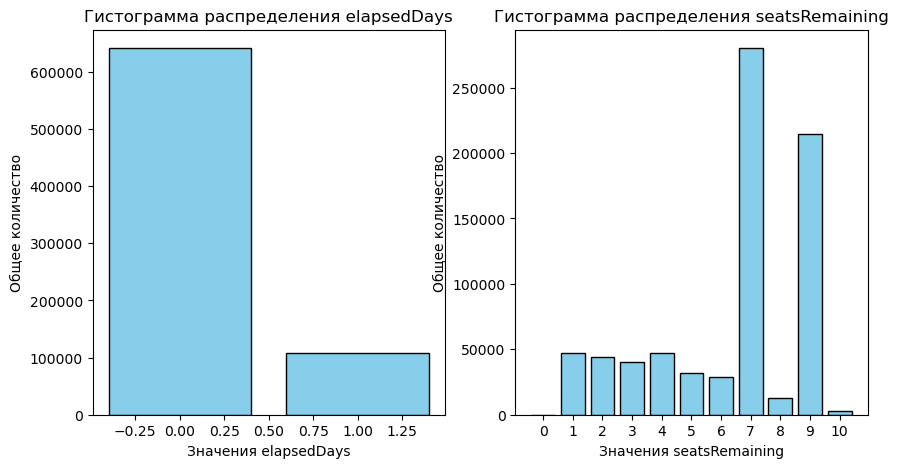

In [71]:
columns = ['elapsedDays', 'seatsRemaining']

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs = axs.ravel()  # Преобразуем матрицу осей в одномерный массив

for i, column in enumerate(columns):
    total_counts = df.groupBy(column).count().collect()

    values = [int(row[column]) for row in total_counts]
    counts = [int(row['count']) for row in total_counts]

    axs[i].bar(values, counts, color='skyblue', edgecolor='black')
    axs[i].set_title(f'Гистограмма распределения {column}')
    axs[i].set_xlabel(f'Значения {column}')
    axs[i].set_ylabel('Общее количество')
    axs[i].set_yscale('linear')

plt.xticks(values)
plt.show()

**Круговые диграммы распределения бинарных признаков:**

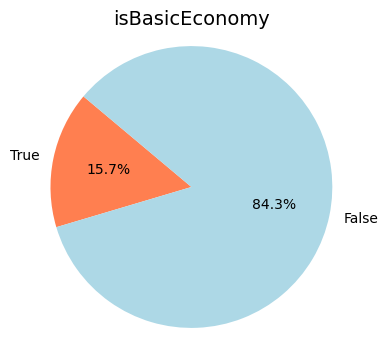

In [40]:
columns = ['isBasicEconomy']
for column in columns:
    column_counts = df.groupBy(column).count().collect()
    labels = [str(row[column]) for row in column_counts]
    sizes = [int(row['count']) for row in column_counts]
    colors = ['coral', 'lightblue']

    plt.figure(figsize=(4, 4))
    plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
    plt.axis('equal')
    plt.title(column, fontsize=14)
    clear_output(wait=True) 

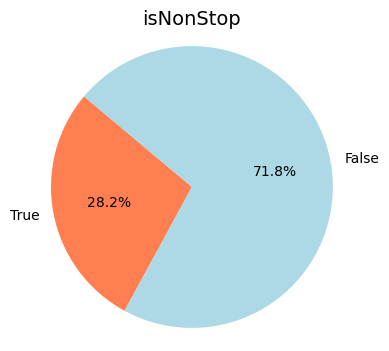

In [41]:
columns = ['isNonStop']
for column in columns:
    column_counts = df.groupBy(column).count().collect()
    labels = [str(row[column]) for row in column_counts]
    sizes = [int(row['count']) for row in column_counts]
    colors = ['coral', 'lightblue']

    plt.figure(figsize=(4, 4))
    plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
    plt.axis('equal')
    plt.title(column, fontsize=14)
    clear_output(wait=True) 

**Круговые диграммы распределения категориальных признаков:**

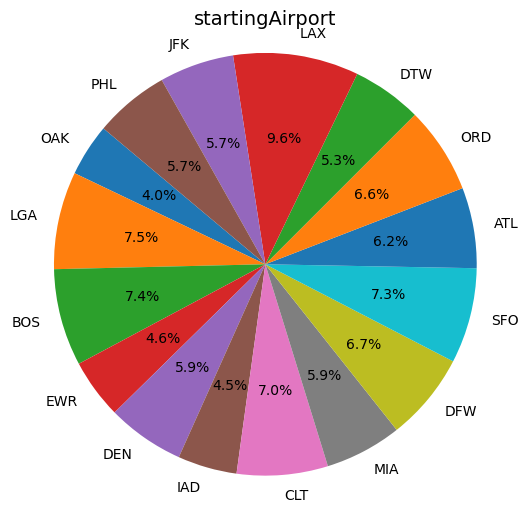

In [42]:
columns = ['startingAirport']
for column in columns:
    column_counts = df.groupBy(column).count().collect()
    labels = [str(row[column]) for row in column_counts]
    sizes = [int(row['count']) for row in column_counts]

    plt.figure(figsize=(6, 6))
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
    plt.axis('equal')
    plt.title(column, fontsize=14)
    clear_output(wait=True) 

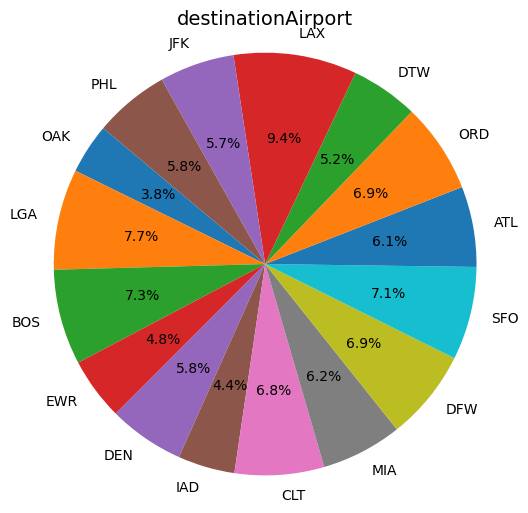

In [43]:
columns = ['destinationAirport']
for column in columns:
    column_counts = df.groupBy(column).count().collect()
    labels = [str(row[column]) for row in column_counts]
    sizes = [int(row['count']) for row in column_counts]

    plt.figure(figsize=(6, 6))
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
    plt.axis('equal')
    plt.title(column, fontsize=14)
    clear_output(wait=True) 

In [60]:
df.limit(10).toPandas()

,startingAirport,destinationAirport,elapsedDays,isBasicEconomy,isNonStop,baseFare,totalFare,seatsRemaining,totalTravelDistance,totalFlightDurationInSeconds
0,ATL,BOS,0,False,True,367.98,410.18,1,947,9840
1,ATL,DEN,0,False,False,262.33,305.61,7,1375,16800
2,ATL,DFW,0,False,False,174.88,211.60,2,1399,17160
3,ATL,MIA,0,False,False,503.51,564.87,5,1866,20040
4,ATL,OAK,0,False,False,528.37,596.10,2,2393,25680
5,ATL,PHL,0,False,True,636.28,698.60,3,667,7320
6,ATL,SFO,0,False,False,496.74,557.60,2,2161,21900
7,BOS,CLT,0,False,True,734.88,804.60,1,728,8940
8,BOS,MIA,1,False,False,301.40,347.61,1,2054,22200
9,BOS,ORD,0,False,True,185.58,214.10,1,862,10620
